In [75]:
from data.prepareData import fetch_sarif_dataframes
import pandas as pd
import os

# Define the input variables
GITHUB_TOKEN = "c3poXD"
REPO_OWNER = "alaynfm"
REPO_NAME = "techFriday"
WORKFLOW_ID = "comparative.yaml"

sarif_dataframes_by_tool = fetch_sarif_dataframes(GITHUB_TOKEN, REPO_OWNER, REPO_NAME, WORKFLOW_ID)

Downloaded combined-sarif-awsGoat.zip to data/downloads/combined-sarif-awsGoat.zip.zip
Downloaded combined-sarif-awsTerraGoat.zip to data/downloads/combined-sarif-awsTerraGoat.zip.zip
Downloaded combined-sarif-azGoat.zip to data/downloads/combined-sarif-azGoat.zip.zip
Downloaded combined-sarif-azTerraGoat.zip to data/downloads/combined-sarif-azTerraGoat.zip.zip


In [76]:
import pandas as pd
import json
import glob
import os
import shutil

files = ["awsGoat", "azGoat", "azTerraGoat", "awsTerraGoat"]
dataframes = []

for file in files:
    # Determine cloud provider based on the prefix in the filename
    if file.startswith("aws"):
        cloud = "aws"
        infra = file[3:].lower()  # Skip the first 3 characters for aws
    else:
        cloud = "az"
        infra = file[2:].lower()  # Skip the first 2 characters for az

    # Unpack archives
    shutil.unpack_archive("data/downloads/combined-sarif-" + file + ".zip.zip", "data/downloads")
    shutil.unpack_archive("data/downloads/combined-sarif-" + file + ".zip", "data")

    # Process each SARIF file
    sarif_files = glob.glob('data/*.sarif')
    for sarif_file in sarif_files:
        # Determine tool based on the file name
        if 'results' in os.path.basename(sarif_file):
            tool = "checkov"
        else:
            tool = "tfsec"

        with open(sarif_file, 'r') as f:
            data = json.load(f)
            df = pd.json_normalize(data, record_path=['runs', 'results'])
            df['cloud'] = cloud  
            df['infra'] = infra  
            df['tool'] = tool  # Add the tool column based on file name
            dataframes.append(df)

        # Delete the SARIF file after processing
        os.remove(sarif_file)

# Combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

In [77]:
print(combined_df.columns.tolist())
combined_df

['ruleId', 'ruleIndex', 'level', 'attachments', 'locations', 'message.text', 'cloud', 'infra', 'tool']


,ruleId,ruleIndex,level,attachments,locations,message.text,cloud,infra,tool
0,CKV_AWS_283,0.0,error,[],[{'physicalLocation': {'artifactLocation': {'u...,Ensure no IAM policies documents allow ALL or ...,aws,goat,checkov
1,CKV_AWS_283,0.0,error,[],[{'physicalLocation': {'artifactLocation': {'u...,Ensure no IAM policies documents allow ALL or ...,aws,goat,checkov
2,CKV_AWS_115,1.0,error,[],[{'physicalLocation': {'artifactLocation': {'u...,Ensure that AWS Lambda function is configured ...,aws,goat,checkov
3,CKV_AWS_116,2.0,error,[],[{'physicalLocation': {'artifactLocation': {'u...,Ensure that AWS Lambda function is configured ...,aws,goat,checkov
4,CKV_AWS_50,3.0,error,[],[{'physicalLocation': {'artifactLocation': {'u...,X-Ray tracing is enabled for Lambda,aws,goat,checkov
...,...,...,...,...,...,...,...,...,...
771,CKV2_AWS_61,86.0,error,[],[{'physicalLocation': {'artifactLocation': {'u...,Ensure that an S3 bucket has a lifecycle confi...,aws,terragoat,checkov
772,CKV2_AWS_61,86.0,error,[],[{'physicalLocation': {'artifactLocation': {'u...,Ensure that an S3 bucket has a lifecycle confi...,aws,terragoat,checkov
773,CKV2_AWS_61,86.0,error,[],[{'physicalLocation': {'artifactLocation': {'u...,Ensure that an S3 bucket has a lifecycle confi...,aws,terragoat,checkov
774,CKV2_AWS_61,86.0,error,[],[{'physicalLocation': {'artifactLocation': {'u...,Ensure that an S3 bucket has a lifecycle confi...,aws,terragoat,checkov


In [78]:
combined_df = combined_df.drop(['attachments', 'ruleIndex', "locations"], axis=1)
print(combined_df.columns.tolist())
combined_df

['ruleId', 'level', 'message.text', 'cloud', 'infra', 'tool']


,ruleId,level,message.text,cloud,infra,tool
0,CKV_AWS_283,error,Ensure no IAM policies documents allow ALL or ...,aws,goat,checkov
1,CKV_AWS_283,error,Ensure no IAM policies documents allow ALL or ...,aws,goat,checkov
2,CKV_AWS_115,error,Ensure that AWS Lambda function is configured ...,aws,goat,checkov
3,CKV_AWS_116,error,Ensure that AWS Lambda function is configured ...,aws,goat,checkov
4,CKV_AWS_50,error,X-Ray tracing is enabled for Lambda,aws,goat,checkov
...,...,...,...,...,...,...
771,CKV2_AWS_61,error,Ensure that an S3 bucket has a lifecycle confi...,aws,terragoat,checkov
772,CKV2_AWS_61,error,Ensure that an S3 bucket has a lifecycle confi...,aws,terragoat,checkov
773,CKV2_AWS_61,error,Ensure that an S3 bucket has a lifecycle confi...,aws,terragoat,checkov
774,CKV2_AWS_61,error,Ensure that an S3 bucket has a lifecycle confi...,aws,terragoat,checkov


In [79]:
print(combined_df['tool'].unique())
print(combined_df['cloud'].unique())
print(combined_df['infra'].unique())

['checkov' 'tfsec']
['aws' 'az']
['goat' 'terragoat']


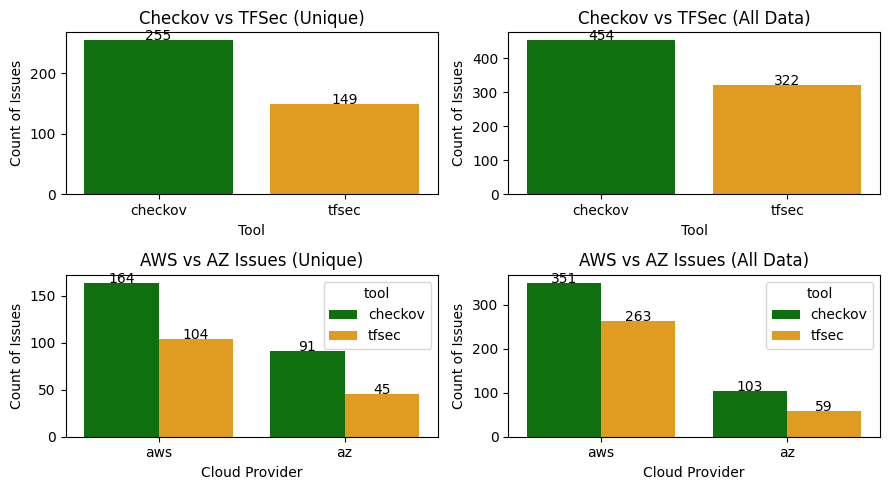

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

customPalette = ['green', 'orange']

# Function to add counts on bars
def add_counts(ax):
    for patch in ax.patches:
        height = patch.get_height()
        if not pd.isna(height) and height > 0:
            ax.annotate(f'{int(height)}', 
                        (patch.get_x() + patch.get_width() / 2, height), 
                        ha='center', va='baseline')

# Create a figure with 2 rows and 2 columns, smaller graphs
fig, axes = plt.subplots(2, 2, figsize=(9, 5))

# Data without duplicates
unique_combined_df = combined_df.drop_duplicates(subset=['ruleId', 'level', 'message.text', 'cloud', 'infra', 'tool'])

# Plot 1: Tool comparison (Unique)
sns.countplot(data=unique_combined_df, x='tool', hue='tool', palette=customPalette, ax=axes[0, 0], dodge=False)
axes[0, 0].set_title('Checkov vs TFSec (Unique)')
axes[0, 0].set_xlabel('Tool')
axes[0, 0].set_ylabel('Count of Issues')
add_counts(axes[0, 0])

# Plot 2: Cloud comparison (Unique)
sns.countplot(data=unique_combined_df, x='cloud', hue='tool', palette=customPalette, ax=axes[1, 0])
axes[1, 0].set_title('AWS vs AZ Issues (Unique)')
axes[1, 0].set_xlabel('Cloud Provider')
axes[1, 0].set_ylabel('Count of Issues')
add_counts(axes[1, 0])

# Plot 3: Tool comparison (All Data)
sns.countplot(data=combined_df, x='tool', hue='tool', palette=customPalette, ax=axes[0, 1], dodge=False)
axes[0, 1].set_title('Checkov vs TFSec (All Data)')
axes[0, 1].set_xlabel('Tool')
axes[0, 1].set_ylabel('Count of Issues')
add_counts(axes[0, 1])

# Plot 4: Cloud comparison (All Data)
sns.countplot(data=combined_df, x='cloud', hue='tool', palette=customPalette, ax=axes[1, 1])
axes[1, 1].set_title('AWS vs AZ Issues (All Data)')
axes[1, 1].set_xlabel('Cloud Provider')
axes[1, 1].set_ylabel('Count of Issues')
add_counts(axes[1, 1])

# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()